In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import evoMPS.tdvp_uniform as mps
from evoMPS import tdvp_common as tm
from evoMPS import mps_sandwich as mps_s
from evoMPS import tdvp_sandwich as sw
import scipy.linalg as la

In [25]:
# evoMPS Parameters
N_window = 500     # Window size
bonds = 32         # Bond dimension
steps = 400        # Number of time steps
dt = 0.08          # Time step size

# Physical Parameters
gx = 1.07         # Ising coupling strength
gz = 0.0132        # Transverse field strength
k0 = 0.5 * np.pi   # Initial momentum
n0 = 150           # Initial position         
sigma = 20         # Wavepacket width

In [26]:
def get_hamiltonian(g_x, g_z):
    """
    Constructs the Hamiltonian with Transverse (g_x) and Longitudinal (g_z) fields.
    H = - sum( Z_i Z_{i+1} + g_x X_i + g_z Z_i )
    
    We construct a 2-site local tensor h_{i, j}. The single site terms are 
    assigned to the first site (i) of the bond to ensure correct summation 
    in the thermodynamic limit.
    """
    sx = np.array([[0, 1], [1, 0]], dtype=np.float64)
    sz = np.array([[1, 0], [0, -1]], dtype=np.float64)
    eye = np.eye(2, dtype=np.float64)
    
    # 1. Interaction Term: - Z_i * Z_{i+1}
    # We take the Kronecker product of Z and Z
    H_interaction = -np.kron(sz, sz)
    
    # 2. Transverse Field Term: - g_x * X_i
    # Acts on the left site (sx), Identity on the right site (eye)
    H_transverse = -g_x * np.kron(sx, eye)
    
    # 3. Longitudinal Field Term: - g_z * Z_i
    # Acts on the left site (sz), Identity on the right site (eye)
    H_longitudinal = -g_z * np.kron(sz, eye)
    
    # Combine all terms
    ham = H_interaction + H_transverse + H_longitudinal
    
    # Reshape into rank-4 tensor (d, d, d, d) required by evoMPS
    # Structure: (input_left, input_right, output_left, output_right)
    return ham.reshape((2, 2, 2, 2))

In [27]:
def find_infinite_ground_state(ham, D=10, q=2, tol=1e-6):
    """
    Finds the ground state of the infinite lattice using Imaginary Time Evolution (TDVP).
    
    Args:
        ham: The Hamiltonian tensor.
        D: Bond dimension.
        q: Local dimension.
        tol: Convergence tolerance for eta (error parameter).
        
    Returns:
        sim: The optimized evoMPS simulation object containing the Ground State tensors.
    """
    print("--- Finding Infinite Ground State ---")
    sim = mps.EvoMPS_TDVP_Uniform(D, q, ham)
    
    eta = 1.0 
    step = 0
    while eta > tol:
        sim.update()
        sim.take_step(0.08) # Imaginary time step
        eta = sim.eta.real
        
        if step % 100 == 0:
            print(f"GS Optimization Step {step}: eta = {eta:.2e}", end='\r')
        step += 1
    
    sim.update() # Final update to lock in canonical form
    print(f"\nGround State found. Final eta: {eta:.2e}")
    return sim

In [28]:
def create_generalized_w_state(sim, N_window, k0, n0, sigma, shape='gaussian'):
    """
    Method A: Creates the Generalized W State ansatz |W(k0)>.
    
    This constructs a superposition of single-particle excitations:
        |W(k0)> = sum_n c_n * e^{i * phi_n} * |n>
    
    Args:
        shape (str): 'gaussian' for wavepacket, 'uniform' for canonical W state (flat box).
    """
    print(f"--- Preparing Ansatz: Generalized W State ({shape}) ---")
    D = sim.D
    q = sim.q
    
    # --- A. Get Tangent Vectors (B-tensors) ---
    # 1. Left packet (+k0)
    _, e_vec_left = sim.excite_top_triv(k0, nev=1, return_eigenvectors=True)
    sim.calc_l_r_roots()
    Vsh0 = tm.calc_Vsh(sim.A[0], sim.r_sqrt[0])
    
    x0_left = e_vec_left[:, 0].reshape(D, D * (q - 1))
    B_left_base = sim.get_B_from_x(x0_left, Vsh0, sim.l_sqrt_i[-1], sim.r_sqrt_i[0])
    B_left_base *= np.exp(-1j * np.angle(B_left_base[0, 0, 0])) 

    # 2. Right packet (-k0)
    _, e_vec_right = sim.excite_top_triv(-k0, nev=1, return_eigenvectors=True)
    x0_right = e_vec_right[:, 0].reshape(D, D * (q - 1))
    B_right_base = sim.get_B_from_x(x0_right, Vsh0, sim.l_sqrt_i[-1], sim.r_sqrt_i[0])
    B_right_base *= np.exp(-1j * np.angle(B_right_base[0, 0, 0]))

    # --- B. Construct Coefficients (Magnitude and Phase) ---
    window_list = []
    
    # Calculate Magnitudes (c_n)
    if shape == 'uniform':
        # Canonical W state profile: Flat box
        mag_L = [1.0 for _ in range(N_window // 2)]
        mag_R = [1.0 for _ in range(N_window // 2, N_window)]
    else:
        # Gaussian Wavepacket profile (Eq 4)
        mag_L = [np.exp(-(n - n0)**2 / (2 * sigma**2)) for n in range(N_window // 2)]
        mag_R = [np.exp(-(n - (N_window - n0))**2 / (2 * sigma**2)) for n in range(N_window // 2, N_window)]

    # Normalize coefficients
    norm_L = np.sqrt(np.sum(np.abs(mag_L)**2))
    norm_R = np.sqrt(np.sum(np.abs(mag_R)**2))

    # Build Tensors
    # Left Half (Packet 1)
    for n in range(N_window // 2):
        c_n = mag_L[n] / norm_L
        phi_n = k0 * (n - n0)
        B_site = np.exp(1j * phi_n) * c_n * B_left_base
        window_list.append(B_site)
        
    # Right Half (Packet 2)
    for n in range(N_window // 2, N_window):
        center_R = N_window - n0
        c_n = mag_R[n - N_window // 2] / norm_R
        phi_n = -k0 * (n - center_R)
        B_site = np.exp(1j * phi_n) * c_n * B_right_base
        window_list.append(B_site)
        
    return window_list

In [29]:
def sew_window(sim, window_list, N_window):
    """
    Sews the excitation B-tensors into the Ground State A-tensors.
    This expands the bond dimension to create the superposition state.
    """
    A_gs = sim.A[0]
    A0, A1 = A_gs[0], A_gs[1]
    
    sewn = []
    
    # 1. Left Boundary: Block Row [GS, Excitation]
    b_start = window_list[0]
    sewn.append(np.array([
        np.block([A0, b_start[0]]), 
        np.block([A1, b_start[1]])
    ]))
    
    # 2. Bulk: Block Diagonal (GS on diagonal)
    for i in range(1, N_window - 1):
        b_curr = window_list[i]
        # Top Left: GS, Top Right: Excitation, Bottom Right: GS, Bottom Left: 0 
        # This structure propagates the GS and the Excitation in parallel
        top = np.block([[A0, b_curr[0]], [np.zeros_like(A0), A0]])
        bot = np.block([[A1, b_curr[1]], [np.zeros_like(A1), A1]])
        sewn.append(np.array([top, bot]))
        
    # 3. Right Boundary: Block Column [[Excitation], [GS]]
    b_end = window_list[-1]
    sewn.append(np.array([
        np.block([[b_end[0]], [A0]]), 
        np.block([[b_end[1]], [A1]])
    ]))
    
    return sewn

In [30]:
def get_excitation_tensor(sim_gs, k_momentum):
    """
    Generates the B-tensor for a single particle excitation at momentum k.
    Corresponds to creating the basis for projection (Paper Sec II.B).
    """
    D = sim_gs.D
    q = sim_gs.q
    
    # 1. Diagonalize effective Hamiltonian in tangent space to find excitation
    # excite_top_triv finds the lowest energy excitation for momentum k
    omega, e_vec = sim_gs.excite_top_triv(k_momentum, nev=1, return_eigenvectors=True)
    
    # 2. Convert eigenvector x into B-tensor format
    # We need the ground state roots to convert parameterization
    sim_gs.calc_l_r_roots()
    Vsh0 = tm.calc_Vsh(sim_gs.A[0], sim_gs.r_sqrt[0])
    
    x = e_vec[:, 0].reshape(D, D * (q - 1))
    B = sim_gs.get_B_from_x(x, Vsh0, sim_gs.l_sqrt_i[-1], sim_gs.r_sqrt_i[0])
    
    # Fix global phase for consistency
    B *= np.exp(-1j * np.angle(B[0, 0, 0]))
    return B

In [31]:
def contract_mps_overlap(bra_tensors, ket_tensors):
    """
    Computes the inner product <Bra|Ket> of two finite MPS chains.
    Standard zipper contraction from left to right.
    """
    # 1. Robustness Check for None tensors (Safety)
    if ket_tensors[0] is None:
        valid = next((t for t in ket_tensors if t is not None), None)
        if valid is None:
            return 0.0
        # Fallback if site 0 is None (shouldn't happen with correct slicing)
        D_ket_L = valid.shape[1] 
    else:
        # shape is (Physical, Left, Right)
        D_ket_L = ket_tensors[0].shape[1]

    D_bra_L = bra_tensors[0].shape[1]
    
    # 2. Fix Initialization
    # We start with an Identity matrix on the Left bonds (Vacuum <-> Vacuum)
    # Note: This requires that D_bra_L == D_ket_L, which is true for 
    # standard sewing where the left boundary is the ground state.
    if D_bra_L != D_ket_L:
        raise ValueError(f"Left bond dimension mismatch: Bra={D_bra_L}, Ket={D_ket_L}")

    E = np.eye(D_bra_L, dtype=ket_tensors[0].dtype if ket_tensors[0] is not None else complex)
    
    # 3. Contraction Loop
    for i, (A_bra, A_ket) in enumerate(zip(bra_tensors, ket_tensors)):
        if A_ket is None:
            continue # Skip empty sites if any remain
            
        # E shape: (D_bra_L, D_ket_L) -> 'ij'
        # A_ket shape: (d, D_ket_L, D_ket_R) -> 'kjl'
        # A_bra shape: (d, D_bra_L, D_bra_R) -> 'kim'
        # Result E_new: (D_bra_R, D_ket_R) -> 'ml'
        
        # FIX: '->ml' preserves the correct Bra-Ket matrix order. 
        # '->lm' would transpose it and break non-square contractions.
        E = np.einsum('ij,kjl,kim->ml', E, A_ket, A_bra.conj())
        
    return np.trace(E)

In [32]:
def analyze_scattering_probabilities(mps_state, sim_gs, k_mode, separation_gap=10):
    """
    Implements the probability extraction algorithm from Sec II.D.b.
    """
    N = mps_state.N
    
    # FIX: evoMPS sandwich tensors start at index 1. Index 0 is None.
    # We slice [1 : N+1] to get the N valid tensors for the window.
    current_mps_tensors = mps_state.A[1 : N + 1]
    
    # Verify we have the correct number of tensors now
    if len(current_mps_tensors) != N:
        print(f"Shape mismatch! Expected {N} tensors, got {len(current_mps_tensors)}")
        return 0.0, None

    # 1. Get reference B tensors for the particles
    B_plus = get_excitation_tensor(sim_gs, k_mode)
    B_minus = get_excitation_tensor(sim_gs, -k_mode)
    A_vac = sim_gs.A[0]
    
    overlap_matrix = np.zeros((N, N), dtype=np.complex128)
    
    # 2. Scan position basis |n1, n2>
    # We iterate 0 to N-1, which maps to sites 1 to N in the physical lattice
    for n1 in range(5, N - separation_gap - 5): 
        for n2 in range(n1 + separation_gap, N - 5):
            
            # Construct the Bra state tensors for |n1, n2>
            bra_tensors = []
            for i in range(N):
                if i == n1:
                    bra_tensors.append(B_plus) 
                elif i == n2:
                    bra_tensors.append(B_minus) 
                else:
                    bra_tensors.append(A_vac)
            
            # Compute Overlap <n1, n2 | Psi(t)>
            val = contract_mps_overlap(bra_tensors, current_mps_tensors)
            overlap_matrix[n1, n2] = val
            
    # 3. Fourier Transform to Momentum Space
    phase_factor = np.zeros((N, N), dtype=np.complex128)
    for n1 in range(N):
        for n2 in range(N):
            phase_factor[n1, n2] = np.exp(-1j * k_mode * n1) * np.exp(-1j * (-k_mode) * n2)
            
    amplitude = np.sum(overlap_matrix * phase_factor)
    probability = np.abs(amplitude)**2
    
    return probability, overlap_matrix

In [33]:
def run_scattering_evolution_with_checks(sim_gs, tdvp_engine, mps_state, N_window, steps, dt, k0):
    """
    Runs scattering simulation with Initial and Final probability checks (Unitarity).
    """
    print(f"--- Running Real-Time Scattering with Probability Checks ---")
    
    e_gs = sim_gs.expect_2s(sim_gs.ham).real 
    energy_history = []
    
    # --- Initial Probability Check (t=0) ---
    print("\nPerforming Initial State Check (t=0)...")
    # Pass the mps_state (sand) explicitly
    p_initial, _ = analyze_scattering_probabilities(mps_state, sim_gs, k0)
    print(f"Initial 11-Sector Probability (Unnormalized): {p_initial:.4f}")
    
    if p_initial < 1e-5:
        print("WARNING: Initial overlap is extremely low. Check ansatz construction.")
    
    # --- Time Evolution ---
    for i in range(steps):
        if i % 20 == 0:
            print(f"Time Step: {i}/{steps}", end='\r')
        
        tdvp_engine.update()
        current_E = [tdvp_engine.expect_2s(sim_gs.ham, n).real - e_gs for n in range(N_window)]
        energy_history.append(current_E)
        tdvp_engine.take_step_RK4(dt * 1j)
        
    print(f"Time Step: {steps}/{steps}")
    
    # --- Final Probability Check (t=Final) ---
    print("\nPerforming Final State Check (t=End)...")
    # Pass the mps_state (sand) explicitly
    p_final, overlap_mat = analyze_scattering_probabilities(mps_state, sim_gs, k0)
    
    # Normalize according to Eq (22) in the paper: P = P(t) / P(0)
    p_elastic_normalized = p_final / p_initial if p_initial > 0 else 0.0
    
    print(f"-"*40)
    print(f"Scattering Results:")
    print(f"Initial '11' Probability: {p_initial:.4e}")
    print(f"Final '11' Probability:   {p_final:.4e}")
    print(f"Normalized Elastic Scattering Prob (P_11->11): {p_elastic_normalized:.4f}")
    
    deviation = abs(1.0 - p_elastic_normalized)
    if deviation < 0.1:
        print("SUCCESS: Probability conserved (Elastic regime valid).")
    else:
        print(f"NOTICE: Probability sum deviates by {deviation:.2f}. Possible Inelastic scattering or Loss.")
    print(f"-"*40)

    return np.array(energy_history)

In [34]:
# 1. Find Vacuum Ground State
hamiltonian = get_hamiltonian(gx, gz)
sim_gs = find_infinite_ground_state(hamiltonian, bonds)

# 2. Create Initial Ansatz (W-State)
w_tensors = create_generalized_w_state(sim_gs, N_window, k0, n0, sigma, shape='gaussian')
sewn_window = sew_window(sim_gs, w_tensors, N_window)
sand = mps_s.sandwich_from_tensors(sim_gs.A, sewn_window, sim_gs.A)

# 3. Initialize TDVP Engine Directly (Skipping VQE)
print("--- Initializing TDVP Engine ---")

tdvp_engine = sw.EvoMPS_TDVP_Sandwich.from_mps(
    sand,
    ham_L=sim_gs.ham,
    ham_C=[sim_gs.ham] * (sand.N + 1),
    ham_R=sim_gs.ham,
    ham_sites=sim_gs.ham_sites
)
# Perform one update to set up environments before stepping
tdvp_engine.update()

# 4. Run Real-Time Scattering
results = run_scattering_evolution_with_checks(sim_gs, tdvp_engine, sand, N_window, steps, dt, k0)

--- Finding Infinite Ground State ---
GS Optimization Step 300: eta = 1.50e-05
Ground State found. Final eta: 9.38e-07
--- Preparing Ansatz: Generalized W State (gaussian) ---
--- Initializing TDVP Engine ---
Bulk eta:  [6.99719334e+09+0.j]
--- Running Real-Time Scattering with Probability Checks ---

Performing Initial State Check (t=0)...


KeyboardInterrupt: 

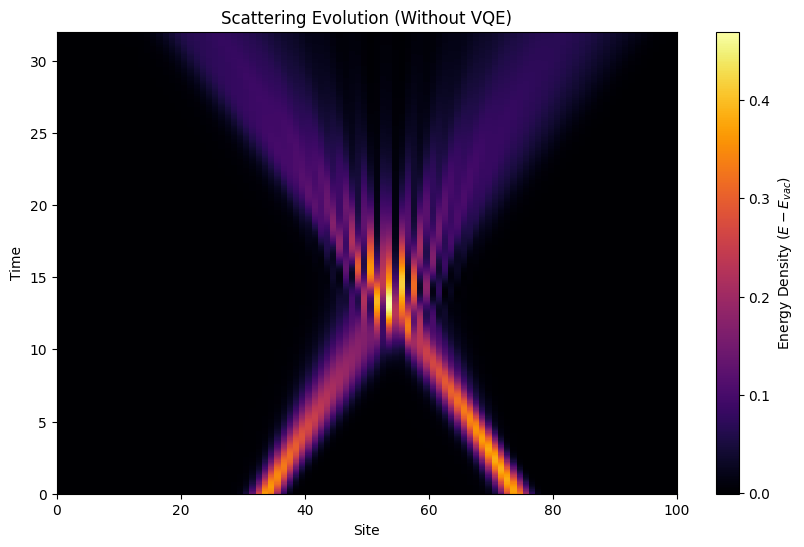

In [ ]:
# 5. Plot using a logarithmic color scale

T, N = results.shape
plt.figure(figsize=(10, 6))
plt.imshow(
    results,
    origin="lower",
    interpolation="none",
    aspect="auto",
    extent=[0, N, 0, T * dt],
    cmap='inferno'
)
plt.colorbar(label=r'Energy Density $(E - E_{vac})$')
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Scattering Evolution (Without VQE)")

save_folder = "simulation_plots"
os.makedirs(save_folder, exist_ok=True)
filename = f"scattering_gx_{gx}_gz_{gz}_k0_{k0:.2f}_sigma_{sigma}_N_{N}_dt_{dt}.png"
full_path = os.path.join(save_folder, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')

plt.show()